In [4]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from groq import Groq
from dotenv import load_dotenv
import os

load_dotenv('/Users/kiara/Documents/matkassen-etl-pipeline/.env')
client = Groq(api_key=os.getenv("GROQ_API_KEY"))

conn = sqlite3.connect('/Users/kiara/Documents/matkassen-etl-pipeline/matkassen-etl/notebook/matkassen.db')
df = pd.read_sql('SELECT * FROM matkassen_tvattad', conn)
conn.close()

df_sentiment = df[df['omdöme_text'].notna()].copy()
print(f"Antal omdömen att analysera: {len(df_sentiment)}")
df_sentiment['omdöme_text'].head(5)

Antal omdömen att analysera: 1117


1            Älskar att slippa planera middagar. Tack!
2    Svamprisotto var verkligen inte gott. Slängde ...
3           Priset är högt men sparar tid. På gränsen.
4        Fungerar, men recepten börjar bli repetitiva.
9                 Snabb leverans och allt var fräscht.
Name: omdöme_text, dtype: object

In [6]:

sample_n = 30  
df_sample = df_sentiment.sample(sample_n, random_state=42).copy()

print("Sample size:", len(df_sample))
df_sample["omdöme_text"].head()

Sample size: 30


2515    Ok kvalitet men Fläskfilé med gräddsås var int...
240              Bra variation och tydliga instruktioner.
1222    Ok kvalitet men Laxfile med potatismos var int...
2177    Överraskad över hur gott det blev! Ny favoritr...
2715    Perfekta portionsstorlekar och fräscha ingredi...
Name: omdöme_text, dtype: object

In [7]:
texts = df_sample["omdöme_text"].astype(str).tolist()

batch_size = 10
sentiments = []

for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    sentiments.extend(analysera_sentiment_batch(batch))
    print(f"✅ {min(i+batch_size, len(texts))}/{len(texts)}")

df_sample["sentiment"] = sentiments

df_sample["sentiment"].value_counts()

✅ 10/30
✅ 20/30
✅ 30/30


sentiment
Positiv    15
Neutral     8
Negativ     7
Name: count, dtype: int64

In [5]:
def analysera_sentiment_batch(texter):
    numrerade = "\n".join([f"{i+1}. {t}" for i, t in enumerate(texter)])
    try:
        response = client.chat.completions.create(
            model="llama-3.3-70b-versatile",
            messages=[
                {"role": "system", "content": "Du är en sentimentanalysmodell. Du får en numrerad lista med omdömen. Svara med ENDAST en numrerad lista med ett ord per rad: Positiv, Neutral eller Negativ."},
                {"role": "user", "content": f"Klassificera dessa omdömen:\n{numrerade}"}
            ],
            max_tokens=500
        )
        svar = response.choices[0].message.content.strip().split("\n")
        resultat = []
        for rad in svar:
            rad = rad.strip()
            if "Positiv" in rad:
                resultat.append("Positiv")
            elif "Negativ" in rad:
                resultat.append("Negativ")
            else:
                resultat.append("Neutral")
        while len(resultat) < len(texter):
            resultat.append("Neutral")
        return resultat[:len(texter)]
    except Exception as e:
        print(f"Fel: {e}")
        return ["Neutral"] * len(texter)

batch_size = 50
sentiments = []
texter = df_sentiment['omdöme_text'].tolist()

for i in range(0, len(texter), batch_size):
    batch = texter[i:i+batch_size]
    resultat = analysera_sentiment_batch(batch)
    sentiments.extend(resultat)
    print(f"✅ Analyserat {min(i+batch_size, len(texter))}/{len(texter)}")

df_sentiment['sentiment'] = sentiments
print("\nKlart!")
print(df_sentiment['sentiment'].value_counts())

✅ Analyserat 50/1117
Fel: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01khy61hmze339xkjeb42bdm1n` service tier `on_demand` on tokens per day (TPD): Limit 100000, Used 99871, Requested 997. Please try again in 12m29.952s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
✅ Analyserat 100/1117
Fel: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01khy61hmze339xkjeb42bdm1n` service tier `on_demand` on tokens per day (TPD): Limit 100000, Used 99871, Requested 973. Please try again in 12m9.216s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
✅ Analyserat 150/1117
Fel: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.3-70b-versatile` in orga

✅ Sparad: sentiment_analys.png


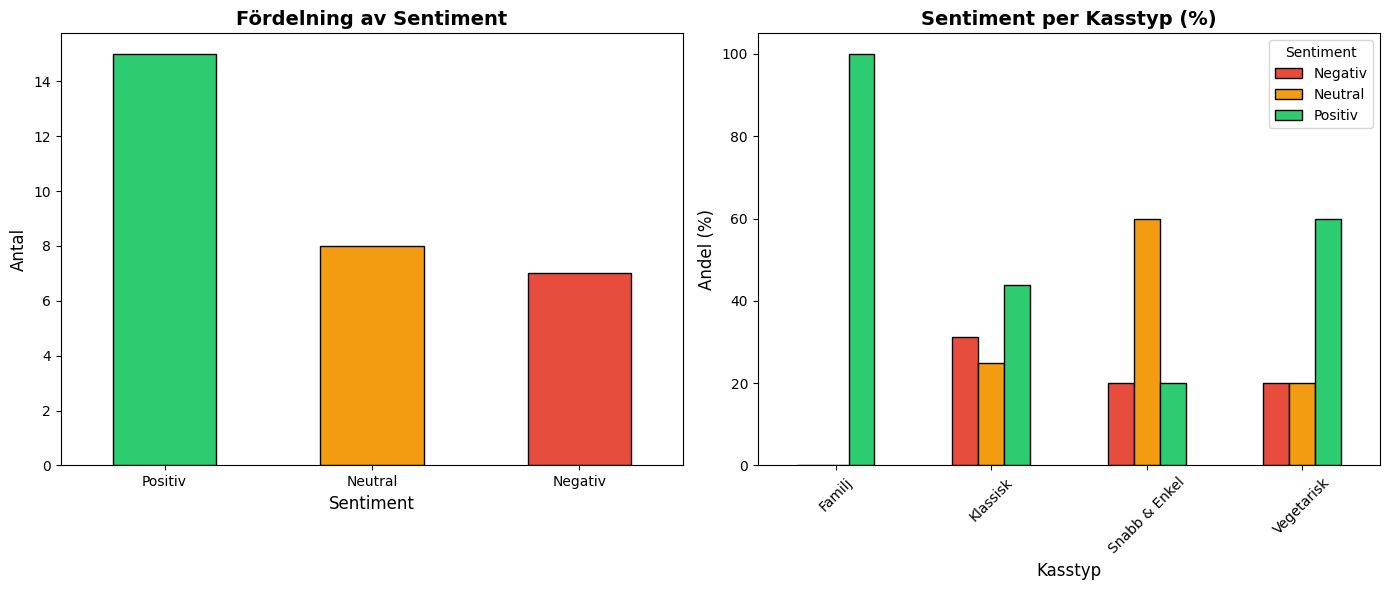

In [8]:
# Använd samplet (undviker rate limit + gör notebooken stabil)
plot_df = df_sample

import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Graf 1: Fördelning av sentiment
sentiment_counts = plot_df["sentiment"].value_counts()
colors_list = {"Positiv": "#2ecc71", "Neutral": "#f39c12", "Negativ": "#e74c3c"}

sentiment_counts.plot(
    kind="bar",
    ax=axes[0],
    color=[colors_list.get(x, "gray") for x in sentiment_counts.index],
    edgecolor="black",
)
axes[0].set_title("Fördelning av Sentiment", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Antal", fontsize=12)
axes[0].set_xlabel("Sentiment", fontsize=12)
axes[0].tick_params(axis="x", rotation=0)

# Graf 2: Sentiment per kasstyp (%)
sentiment_kass = (
    pd.crosstab(plot_df["kasstyp"], plot_df["sentiment"], normalize="index") * 100
)
sentiment_kass.plot(
    kind="bar",
    ax=axes[1],
    color=[colors_list.get(x, "gray") for x in sentiment_kass.columns],
    edgecolor="black",
)
axes[1].set_title("Sentiment per Kasstyp (%)", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Andel (%)", fontsize=12)
axes[1].set_xlabel("Kasstyp", fontsize=12)
axes[1].tick_params(axis="x", rotation=45)
axes[1].legend(title="Sentiment")

plt.tight_layout()
plt.savefig("sentiment_analys.png", dpi=300, bbox_inches="tight")
print("✅ Sparad: sentiment_analys.png")
plt.show()